# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 7  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

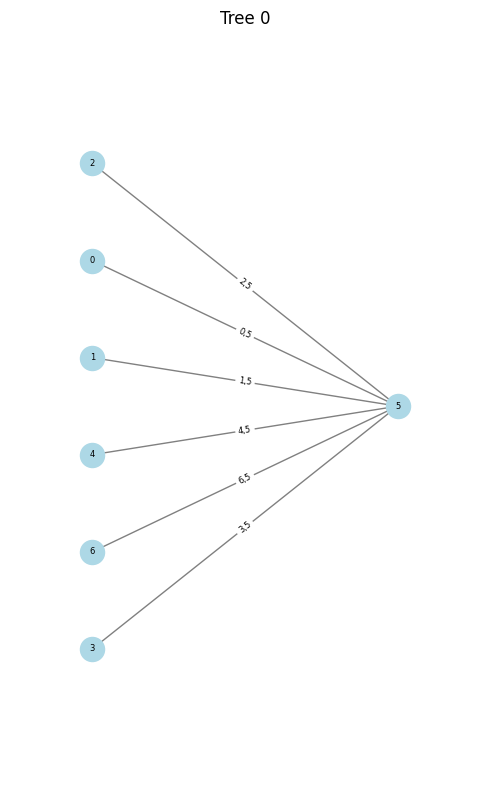

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-09 17:23:00,159] A new study created in RDB with name: no-name-ef2c4f18-6377-411f-a21b-e6df26726086
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 4/2000 [00:00<02:51, 11.64it/s]

current_loss: tensor(1.4310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4380080699920654
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4312653541564941
current_loss: tensor(1.4221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4253054857254028
current_loss: tensor(1.4133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.425244688987732


  0%|          | 7/2000 [00:00<02:09, 15.41it/s]

current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.425189733505249
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.425102949142456
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4249576330184937
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4248359203338623
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424764633178711


  1%|          | 14/2000 [00:00<01:23, 23.78it/s]

current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424687147140503
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4246808290481567
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4245679378509521
current_loss: tensor(1.4129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4244991540908813
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4244883060455322
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, d

  1%|          | 18/2000 [00:00<01:44, 18.99it/s]


current_loss: tensor(1.4127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424554705619812
current_loss: tensor(1.4126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4245874881744385
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4246046543121338
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4246238470077515
Early Stop at iteration 18 with minimal loss tensor(1.4245, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.328395962715149
current_loss: tensor(1.3240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1844770908355713
current_loss: tensor(1.1955, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:50, 11.71it/s]

current_loss: tensor(1.5365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1652703285217285
current_loss: tensor(1.1766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1467864513397217
current_loss: tensor(1.1581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1138955354690552


  0%|          | 7/2000 [00:00<02:40, 12.46it/s]

current_loss: tensor(1.1293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1085747480392456
current_loss: tensor(1.1261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0987664461135864
current_loss: tensor(1.1157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0955685377120972


  1%|          | 11/2000 [00:00<02:26, 13.62it/s]

current_loss: tensor(1.1123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.091793179512024
current_loss: tensor(1.1074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0843802690505981
current_loss: tensor(1.0953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0797817707061768


  1%|          | 13/2000 [00:01<02:23, 13.89it/s]

current_loss: tensor(1.0890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0752493143081665
current_loss: tensor(1.0840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.071153998374939
current_loss: tensor(1.0792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0663648843765259


  1%|          | 17/2000 [00:01<02:19, 14.23it/s]

current_loss: tensor(1.0749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.061066746711731
current_loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0526658296585083
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0408085584640503


  1%|          | 19/2000 [00:01<02:18, 14.32it/s]

current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.034278154373169
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0289101600646973
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0278044939041138


  1%|          | 21/2000 [00:01<02:18, 14.34it/s]

current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0230721235275269
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0221704244613647
current_loss: tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0312, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:28, 13.28it/s]

current_loss_val:  1.0216220617294312
current_loss: tensor(1.0312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0198535919189453
current_loss: tensor(1.0288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0192677974700928
current_loss: tensor(1.0284, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:24, 13.62it/s]

current_loss: tensor(1.0280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0186930894851685
current_loss: tensor(1.0280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0173509120941162
current_loss: tensor(1.0267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0155084133148193
current_loss: tensor(1.0250, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:19, 14.07it/s]

current_loss: tensor(1.0234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0120588541030884
current_loss: tensor(1.0234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.010414481163025
current_loss: tensor(1.0221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0094046592712402
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:19, 14.11it/s]

current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0061366558074951
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0026923418045044
current_loss: tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0003169775009155
current_loss: tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:16, 14.36it/s]

current_loss: tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9973981976509094
current_loss: tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9948738217353821
current_loss: tensor(1.0124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9920418858528137
current_loss: tensor(1.0102, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:16, 14.38it/s]

current_loss: tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9894052743911743
current_loss: tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9890282154083252
current_loss: tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885897636413574
current_loss: tensor(1.0073, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:21, 13.80it/s]

current_loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885563254356384
current_loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.992647111415863
current_loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.991206169128418


  2%|▏         | 45/2000 [00:03<02:26, 13.34it/s]

current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9910392761230469
current_loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9902926087379456
current_loss: tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9894728064537048
Early Stop at iteration 45 with minimal loss tensor(0.9886, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:23:07,454] Trial 0 finished with value: -6.919894695281982 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.186566403366408, 'penalty_decorrelation_ridge_second_difference': 18.975513734608107}. Best is trial 0 with value: -6.919894695281982.
  0%|          | 1/2000 [00:00<03:24,  9.79it/s]

current_loss: tensor(0.9989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887524247169495
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988578736782074
current_loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:38, 12.55it/s]

current_loss_val:  0.9879642128944397
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9873395562171936
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9865607023239136
current_loss: tensor(0.9938, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:28, 13.39it/s]

current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9865825772285461
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9864289164543152
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9849221706390381
current_loss: tensor(0.9920, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:26, 13.54it/s]

current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.98418790102005
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9840959310531616
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9836301803588867


  1%|          | 13/2000 [00:00<02:30, 13.20it/s]

current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9831985235214233
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9832491278648376
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:33, 12.94it/s]

current_loss_val:  0.9831141233444214
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9825811982154846
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9824646711349487
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 19/2000 [00:01<02:26, 13.50it/s]

tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9822095036506653
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810242652893066
current_loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9803860187530518
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:23, 13.77it/s]

current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9800489544868469
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9771745204925537
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9763783812522888
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:19, 14.17it/s]

current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9763273000717163
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.976036012172699
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731988310813904
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:25, 13.55it/s]

current_loss: tensor(0.9919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.970247209072113
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691630005836487
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671121835708618


  2%|▏         | 31/2000 [00:02<02:20, 14.03it/s]

current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9646404981613159
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.963111162185669
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9621946215629578


  2%|▏         | 33/2000 [00:02<02:19, 14.15it/s]

current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960997462272644
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9597999453544617
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9587752819061279


  2%|▏         | 35/2000 [00:02<02:18, 14.22it/s]

current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586247205734253
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578180909156799
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:21, 13.88it/s]

current_loss_val:  0.9579660892486572
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957503616809845
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571797251701355
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:26, 13.39it/s]

current_loss_val:  0.9567822217941284
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556475281715393
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557195901870728
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:20, 13.91it/s]

current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553413391113281
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549636244773865
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551143646240234
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:20, 13.89it/s]

current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550032615661621
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552927017211914


  2%|▏         | 49/2000 [00:03<03:25,  9.49it/s]

current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548479914665222
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547370076179504
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<03:04, 10.58it/s]

current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556780457496643
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551934599876404
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550681114196777
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:38, 12.24it/s]

current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549406170845032
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544417858123779
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545775651931763
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:31, 12.84it/s]

current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545297026634216
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544779658317566
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545314311981201
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:31, 12.86it/s]


current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955436110496521
Early Stop at iteration 58 with minimal loss tensor(0.9544, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:12,717] Trial 1 finished with value: -6.681092739105225 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.1438624146540817, 'penalty_decorrelation_ridge_second_difference': 12.30452101531634}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 1/2000 [00:00<03:21,  9.94it/s]

current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888076782226562
current_loss: tensor(1.0016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9886435270309448
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:36, 12.76it/s]

current_loss_val:  0.9881798028945923
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9880277514457703
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9873253703117371
current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 7/2000 [00:00<02:27, 13.48it/s]

tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9872990846633911
current_loss: tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.987190306186676
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9861745238304138
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:25, 13.67it/s]

current_loss: tensor(1.0285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9856635928153992
current_loss: tensor(0.9941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9856670498847961
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9858399629592896


  1%|          | 13/2000 [00:00<02:22, 13.97it/s]

current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9855583310127258
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857809543609619
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9852603077888489


  1%|          | 17/2000 [00:01<02:22, 13.95it/s]

current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9849117398262024
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9847323894500732
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9847092628479004


  1%|          | 19/2000 [00:01<02:20, 14.13it/s]

current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9840087890625
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9835811257362366
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9823854565620422


  1%|          | 21/2000 [00:01<02:27, 13.44it/s]

current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.982503354549408
current_loss: tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.982066810131073
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:21, 13.92it/s]

current_loss_val:  0.9792907238006592
current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784742593765259
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9764487147331238
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:01<02:27, 13.37it/s]

current_loss_val:  0.9737017154693604
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712069630622864
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676198363304138
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:22, 13.83it/s]

current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9662918448448181
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9644126296043396
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9625236392021179
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:20, 14.03it/s]

current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9624632000923157
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9627335071563721
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9630962014198303
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:26, 13.39it/s]

current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.963661253452301
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653934836387634
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9647061824798584
Early Stop at iteration 36 with minimal loss tensor(0.9625, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:23:16,068] Trial 2 finished with value: -6.737242698669434 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.477762558029395, 'penalty_decorrelation_ridge_second_difference': 17.232202284178513}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:21, 14.15it/s]

current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9894933700561523
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9897747039794922
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9909886121749878


  0%|          | 4/2000 [00:00<02:33, 13.02it/s]

current_loss: tensor(1.0268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9919536709785461
current_loss: tensor(1.0256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9919146299362183
current_loss: tensor(1.0249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0226, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:57, 11.24it/s]


current_loss_val:  0.9931482672691345
Early Stop at iteration 5 with minimal loss tensor(0.9895, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:17,184] Trial 3 finished with value: -6.926453590393066 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.446763989854237, 'penalty_decorrelation_ridge_second_difference': 25.787149588517412}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 1/2000 [00:00<03:22,  9.89it/s]

current_loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988758385181427
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885756969451904
current_loss: tensor(1.0043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:39, 12.52it/s]

current_loss_val:  0.9879366755485535
current_loss: tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9875451922416687
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9867915511131287
current_loss: tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:30, 13.22it/s]

current_loss: tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9868158102035522
current_loss: tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9866700768470764
current_loss: tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9850919246673584
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:27, 13.48it/s]

current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9843320846557617
current_loss: tensor(0.9975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9842180013656616
current_loss: tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9832585453987122


  1%|          | 13/2000 [00:01<02:31, 13.13it/s]

current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9827855229377747
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9827393889427185
current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:26, 13.59it/s]

current_loss_val:  0.9825289845466614
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9820101857185364
current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9820266366004944
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:26, 13.48it/s]

current_loss_val:  0.9820238351821899
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9817366003990173
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810885787010193
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:22, 13.84it/s]

current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810593724250793
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810632467269897
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9808817505836487
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:23, 13.73it/s]

current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810316562652588
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810585975646973
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.981007993221283
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:31, 13.02it/s]


current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810645580291748
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810649156570435
Early Stop at iteration 26 with minimal loss tensor(0.9809, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:19,906] Trial 4 finished with value: -6.8661723136901855 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.07174179337282, 'penalty_decorrelation_ridge_second_difference': 3.955475759464111}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:23, 13.91it/s]

current_loss: tensor(1.0318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9897853136062622
current_loss: tensor(1.0311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9892168641090393
current_loss: tensor(1.0300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988910973072052


  0%|          | 4/2000 [00:00<02:19, 14.29it/s]

current_loss: tensor(1.0270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9897128939628601
current_loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9904970526695251
current_loss: tensor(1.0213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0209, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:53, 11.51it/s]

current_loss: tensor(1.0183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9917209148406982
current_loss: tensor(1.0183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9942086935043335
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9934888482093811
Early Stop at iteration 7 with minimal loss tensor(0.9889, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:23:21,229] Trial 5 finished with value: -6.922377109527588 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.458981813040513, 'penalty_decorrelation_ridge_second_difference': 18.134641059207485}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:24, 13.82it/s]

current_loss: tensor(1.0316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.989982545375824
current_loss: tensor(1.0312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9890227317810059
current_loss: tensor(1.0303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9883826375007629


  0%|          | 6/2000 [00:00<02:21, 14.10it/s]

current_loss: tensor(1.0293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.98841392993927
current_loss: tensor(1.0282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9904355406761169
current_loss: tensor(1.0239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9924190044403076


  0%|          | 7/2000 [00:00<02:47, 11.90it/s]


current_loss: tensor(1.0198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9929519891738892
current_loss: tensor(1.0194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9928309321403503
Early Stop at iteration 7 with minimal loss tensor(0.9884, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:22,517] Trial 6 finished with value: -6.918677806854248 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.832881317071717, 'penalty_decorrelation_ridge_second_difference': 10.5754561508155}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:26, 13.68it/s]

current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9894775152206421
current_loss: tensor(1.0326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.989732563495636
current_loss: tensor(1.0309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9904720783233643


  0%|          | 4/2000 [00:00<02:35, 12.83it/s]

current_loss: tensor(1.0230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.991349458694458
current_loss: tensor(1.0222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.99134361743927
current_loss: tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0182, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:57, 11.23it/s]


current_loss_val:  0.99334716796875
Early Stop at iteration 5 with minimal loss tensor(0.9895, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:23,666] Trial 7 finished with value: -6.926342964172363 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.198025045751791, 'penalty_decorrelation_ridge_second_difference': 29.74068122872337}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:22, 14.07it/s]

current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9895275831222534
current_loss: tensor(1.0322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9896234273910522
current_loss: tensor(1.0307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0231, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.47it/s]

current_loss_val:  0.9905229806900024
current_loss: tensor(1.0231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9912830591201782
current_loss: tensor(1.0220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.991085410118103
current_loss: tensor(1.0212, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:01, 11.02it/s]


current_loss: tensor(1.0195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.991584837436676
Early Stop at iteration 5 with minimal loss tensor(0.9895, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:24,841] Trial 8 finished with value: -6.926693439483643 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.933836539449228, 'penalty_decorrelation_ridge_second_difference': 27.648728895190995}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:19, 14.29it/s]

current_loss: tensor(1.0572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9892552495002747
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9910948276519775
current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9940619468688965


  0%|          | 4/2000 [00:00<02:32, 13.12it/s]

current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9941809177398682
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9952085614204407
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:15, 10.20it/s]


current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9954273104667664
Early Stop at iteration 5 with minimal loss tensor(0.9893, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:26,038] Trial 9 finished with value: -6.9247870445251465 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.45340372250517, 'penalty_decorrelation_ridge_second_difference': 29.24560177461122}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:49, 11.77it/s]

current_loss: tensor(1.0179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888761043548584
current_loss: tensor(1.0175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887192845344543
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0149, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:32, 13.10it/s]

current_loss_val:  0.9885320663452148
current_loss: tensor(1.0149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9898509979248047
current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9892013072967529
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:29, 13.29it/s]

current_loss: tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9891706109046936
current_loss: tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9890826344490051
current_loss: tensor(1.0098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9882994294166565
current_loss: tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:33, 12.96it/s]

current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9879168272018433
current_loss: tensor(1.0079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9880030751228333
current_loss: tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988311231136322


  1%|          | 12/2000 [00:00<02:28, 13.39it/s]

current_loss: tensor(1.0073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9884962439537048
current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9879183173179626
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0058, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:45, 12.04it/s]


current_loss_val:  0.9879331588745117
Early Stop at iteration 13 with minimal loss tensor(0.9879, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:27,751] Trial 10 finished with value: -6.915417671203613 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.215343421214694, 'penalty_decorrelation_ridge_second_difference': 7.3807469735736175}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:23, 13.91it/s]

current_loss: tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9900766015052795
current_loss: tensor(1.0197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988920271396637
current_loss: tensor(1.0189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9884002208709717


  0%|          | 6/2000 [00:00<02:17, 14.53it/s]

current_loss: tensor(1.0184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9883418679237366
current_loss: tensor(1.0178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9889174103736877
current_loss: tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9897052645683289


  0%|          | 8/2000 [00:00<02:25, 13.67it/s]

current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9901053309440613
current_loss: tensor(1.0106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.989973783493042
current_loss: tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:40, 12.41it/s]


current_loss_val:  0.9897851943969727
Early Stop at iteration 8 with minimal loss tensor(0.9883, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:29,049] Trial 11 finished with value: -6.918392658233643 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.111827522292689, 'penalty_decorrelation_ridge_second_difference': 18.69673065665156}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:25, 13.76it/s]

current_loss: tensor(1.0231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9897606372833252
current_loss: tensor(1.0224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9891763925552368
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887496829032898


  0%|          | 4/2000 [00:00<02:20, 14.24it/s]

current_loss: tensor(1.0187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9891382455825806
current_loss: tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9897915720939636
current_loss: tensor(1.0143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:01, 11.00it/s]

current_loss: tensor(1.0115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9903873801231384
current_loss: tensor(1.0115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9911968111991882
current_loss: tensor(1.0106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9911771416664124
Early Stop at iteration 7 with minimal loss tensor(0.9887, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:23:30,345] Trial 12 finished with value: -6.921247959136963 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.59311164484738, 'penalty_decorrelation_ridge_second_difference': 25.489152859834228}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:47, 11.90it/s]

current_loss: tensor(1.0174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888501763343811
current_loss: tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988684892654419
current_loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0146, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:32, 13.12it/s]

current_loss_val:  0.9883852601051331
current_loss: tensor(1.0146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9894498586654663
current_loss: tensor(1.0109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887770414352417
current_loss: tensor(1.0104, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:29, 13.33it/s]

current_loss: tensor(1.0101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887611269950867
current_loss: tensor(1.0101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9886640310287476
current_loss: tensor(1.0097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9877529740333557
current_loss: tensor(1.0082, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:33, 13.00it/s]

current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9871941804885864
current_loss: tensor(1.0079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9872177839279175
current_loss: tensor(1.0077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.987511157989502


  1%|          | 12/2000 [00:00<02:29, 13.28it/s]

current_loss: tensor(1.0069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9874047040939331
current_loss: tensor(1.0060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.987407922744751
current_loss: tensor(1.0057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:29, 13.30it/s]

current_loss_val:  0.9870654940605164
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9869507551193237
current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9879522919654846
current_loss: tensor(1.0045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:26, 13.57it/s]

current_loss_val:  0.9872027039527893
current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9869621992111206
current_loss: tensor(1.0038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9867203235626221
current_loss: tensor(1.0032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0028, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:21, 13.98it/s]

current_loss_val:  0.9864137768745422
current_loss: tensor(1.0028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9863705039024353
current_loss: tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857572913169861
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9848137497901917
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.985038161277771
current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9844619035720825
current_loss: tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:22, 13.85it/s]

current_loss: tensor(0.9987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9831611514091492
current_loss: tensor(0.9987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9822063446044922
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9795463681221008
current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:28, 13.30it/s]

current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9790689945220947
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784500598907471
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9771009683609009


  2%|▏         | 32/2000 [00:02<02:24, 13.59it/s]

current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742627143859863
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9722187519073486
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:25, 13.52it/s]

current_loss_val:  0.9714277386665344
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694446325302124
current_loss: tensor(0.9916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682445526123047
current_loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:21, 13.84it/s]

current_loss_val:  0.967016339302063
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665855169296265
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659605026245117
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:24, 13.56it/s]

current_loss_val:  0.9654160737991333
current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9644446969032288
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636110663414001
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:28, 13.20it/s]

current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.962552011013031
current_loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9611840844154358
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9613354802131653


  2%|▏         | 48/2000 [00:03<02:21, 13.80it/s]

current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960566520690918
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9603783488273621
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9602888226509094


  2%|▎         | 50/2000 [00:03<02:23, 13.60it/s]

current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9603553414344788
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9602150917053223
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960313618183136


  3%|▎         | 52/2000 [00:03<02:22, 13.71it/s]

current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605073928833008
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9608272910118103
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:27, 13.21it/s]

current_loss_val:  0.961166262626648
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9611035585403442
Early Stop at iteration 54 with minimal loss tensor(0.9602, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:23:35,116] Trial 13 finished with value: -6.721506118774414 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.638942908530488, 'penalty_decorrelation_ridge_second_difference': 3.7221982421730133}. Best is trial 1 with value: -6.681092739105225.
  0%|          | 2/2000 [00:00<02:47, 11.92it/s]

current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988727867603302
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885172843933105
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.21it/s]

current_loss_val:  0.9876360297203064
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.986598014831543
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857099652290344
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.23it/s]

current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9856816530227661
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9853846430778503
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9831711649894714
current_loss: tensor(0.9870, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.84it/s]

current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9822224974632263
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9820340275764465
current_loss: tensor(0.9865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9804748296737671


  1%|          | 12/2000 [00:00<02:38, 12.56it/s]

current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9793183207511902
current_loss: tensor(0.9845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9791908264160156
current_loss: tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.41it/s]

current_loss_val:  0.9788609743118286
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.977283775806427
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9772717356681824
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:25, 13.63it/s]

current_loss_val:  0.9773204326629639
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9772506952285767
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9763280153274536
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:22, 13.91it/s]

current_loss_val:  0.976305365562439
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9759796261787415
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757786989212036
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:21, 14.01it/s]

current_loss_val:  0.9763410091400146
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757512211799622
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755091071128845
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:25, 13.53it/s]

current_loss_val:  0.9751355648040771
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974991500377655
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746466279029846
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:22, 13.84it/s]

current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9741589426994324
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743539094924927
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735492467880249
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:21, 13.93it/s]

current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735512137413025
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735326170921326
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9733320474624634
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:19, 14.05it/s]

current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9733157157897949
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9733272790908813
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732297658920288
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:16, 14.33it/s]

current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731470346450806
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735105633735657
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731221199035645
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:15, 14.42it/s]

current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729147553443909
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725192189216614
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723520874977112
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:14, 14.53it/s]

current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717527627944946
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710900187492371
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9699786901473999
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:14, 14.54it/s]

current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684399366378784
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967731773853302
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9672101140022278
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:20, 13.89it/s]

current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670325517654419
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9666752219200134
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668474793434143


  3%|▎         | 54/2000 [00:03<02:26, 13.29it/s]

current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668373465538025
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668378829956055
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667618274688721


  3%|▎         | 58/2000 [00:04<02:20, 13.77it/s]

current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9663259983062744
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652710556983948
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9650760889053345


  3%|▎         | 60/2000 [00:04<02:19, 13.96it/s]

current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9650949835777283
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9649905562400818
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9645735025405884


  3%|▎         | 64/2000 [00:04<02:17, 14.08it/s]

current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9645230174064636
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9644284844398499
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640814661979675


  3%|▎         | 66/2000 [00:04<02:17, 14.10it/s]

current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640819430351257
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636127352714539
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.962516188621521


  4%|▎         | 70/2000 [00:05<02:17, 14.04it/s]

current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959606945514679
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573912024497986
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565799236297607


  4%|▎         | 72/2000 [00:05<02:16, 14.13it/s]

current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562486410140991
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954939603805542
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9543198347091675


  4%|▎         | 74/2000 [00:05<02:23, 13.41it/s]

current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538080096244812
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535940885543823
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:05<02:20, 13.73it/s]

current_loss_val:  0.9531952738761902
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520644545555115
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519470930099487
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:05<02:18, 13.87it/s]

current_loss_val:  0.9514265656471252
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513670802116394
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516171813011169
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:20, 13.60it/s]

current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517560005187988
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517045021057129
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519727230072021
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:21, 13.55it/s]


current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518477320671082
Early Stop at iteration 84 with minimal loss tensor(0.9514, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:41,996] Trial 14 finished with value: -6.65956974029541 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.29825773974343, 'penalty_decorrelation_ridge_second_difference': 2.714347840886137}. Best is trial 14 with value: -6.65956974029541.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887204766273499
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:59,  8.34it/s]

current_loss_val:  0.9885206818580627
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.987693190574646
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9865627884864807
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0303, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(0.9881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857087135314941
current_loss: tensor(0.9881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9856716990470886
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9853479266166687
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:52, 11.51it/s]

current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9832125902175903
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9822916984558105
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9821229577064514


  1%|          | 12/2000 [00:01<02:48, 11.82it/s]

current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9807887077331543
current_loss: tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9798702597618103
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:37, 12.60it/s]

current_loss_val:  0.9797905683517456
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.979503870010376
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784582853317261
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:31, 13.10it/s]

current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9781473278999329
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9777465462684631
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9761640429496765
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:26, 13.47it/s]

current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757580757141113
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755663871765137
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747195839881897
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:38, 12.51it/s]

current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9737057089805603
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702480435371399
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:34, 12.74it/s]

current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682076573371887
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968376100063324
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683060646057129
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:53, 11.38it/s]

current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683989882469177
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.970710813999176
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702680110931396
Early Stop at iteration 28 with minimal loss tensor(0.9682, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:23:45,135] Trial 15 finished with value: -6.7774529457092285 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.8109033185514494, 'penalty_decorrelation_ridge_second_difference': 6.553949551968583}. Best is trial 14 with value: -6.65956974029541.
  0%|          | 2/2000 [00:00<02:45, 12.09it/s]

current_loss: tensor(0.9882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887310266494751
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9884928464889526
current_loss: tensor(0.9876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.16it/s]

current_loss_val:  0.9874221682548523
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.986228883266449
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851697087287903
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:33, 12.95it/s]

current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9850767850875854
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9844567179679871
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.981540322303772
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:37, 12.63it/s]

current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9805945754051208
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9803504347801208
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9789612293243408


  1%|          | 12/2000 [00:00<02:40, 12.36it/s]

current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9778554439544678
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.977790892124176
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:29, 13.26it/s]

current_loss_val:  0.9775234460830688
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9760620594024658
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9761901497840881
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:26, 13.50it/s]

current_loss_val:  0.9758698344230652
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748790264129639
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739454388618469
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:28, 13.32it/s]

current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725497961044312
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721811413764954
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717645049095154
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:25, 13.61it/s]

current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692961573600769
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696856737136841
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690221548080444
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:29, 13.21it/s]

current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688364267349243
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685680866241455
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690536260604858


  2%|▏         | 30/2000 [00:02<02:25, 13.55it/s]

current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689643979072571
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691085815429688
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686291217803955


  2%|▏         | 31/2000 [00:02<02:34, 12.78it/s]


current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695571660995483
Early Stop at iteration 31 with minimal loss tensor(0.9686, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:48,264] Trial 16 finished with value: -6.7799763679504395 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.6765998875171797, 'penalty_decorrelation_ridge_second_difference': 1.371141016083003}. Best is trial 14 with value: -6.65956974029541.
  0%|          | 2/2000 [00:00<02:21, 14.14it/s]

current_loss: tensor(1.0378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9899317622184753
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9890453815460205
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9883714914321899


  0%|          | 6/2000 [00:00<02:16, 14.62it/s]

current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9884735345840454
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9921748042106628
current_loss: tensor(1.0279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9944496750831604


  0%|          | 7/2000 [00:00<02:42, 12.23it/s]


current_loss: tensor(1.0245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9947142601013184
current_loss: tensor(1.0241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9933282732963562
Early Stop at iteration 7 with minimal loss tensor(0.9884, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:23:49,538] Trial 17 finished with value: -6.918600559234619 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.672718025615982, 'penalty_decorrelation_ridge_second_difference': 2.6238280451935907}. Best is trial 14 with value: -6.65956974029541.
  0%|          | 1/2000 [00:00<03:22,  9.88it/s]

current_loss: tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887926578521729
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9886285662651062
current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:41, 12.38it/s]

current_loss_val:  0.988155722618103
current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9880916476249695
current_loss: tensor(1.0005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9873616099357605
current_loss: tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:32, 13.10it/s]

current_loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9873968362808228
current_loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9873048067092896
current_loss: tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.986160159111023
current_loss: tensor(0.9981, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:37, 12.63it/s]

current_loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9855930209159851
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9854323267936707
current_loss: tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:33, 12.94it/s]

current_loss_val:  0.9856722354888916
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857227206230164
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851521849632263
current_loss: tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:29, 13.31it/s]

current_loss_val:  0.9850908517837524
current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851234555244446
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9848011136054993
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:29, 13.24it/s]

current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9847911596298218
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9845482110977173
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9843524694442749
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:27, 13.40it/s]

current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9846209287643433
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9842297434806824
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9841140508651733
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:24, 13.67it/s]

current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.983863115310669
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9835042953491211
current_loss: tensor(0.9941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.983260452747345
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:23, 13.74it/s]

current_loss: tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9824641346931458
current_loss: tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9823620319366455
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.982037365436554
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:21, 13.89it/s]

current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9808374047279358
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9776742458343506
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742302894592285
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:20, 13.97it/s]

current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736856818199158
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9738723635673523
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9740741848945618
current_loss: tensor(0.9870, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:31, 12.95it/s]

current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9737481474876404
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9737479090690613
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745385050773621
Early Stop at iteration 36 with minimal loss tensor(0.9737, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:23:52,963] Trial 18 finished with value: -6.815799713134766 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.71315408378405, 'penalty_decorrelation_ridge_second_difference': 12.10872006756704}. Best is trial 14 with value: -6.65956974029541.
  0%|          | 1/2000 [00:00<03:20,  9.99it/s]

current_loss: tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887462854385376
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885426759719849
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:36, 12.76it/s]

current_loss_val:  0.9877520799636841
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9871228933334351
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862807989120483
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:27, 13.50it/s]

current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862805604934692
current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.986060380935669
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9840443730354309
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:26, 13.59it/s]

current_loss: tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9831711649894714
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9830054044723511
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9815812110900879


  1%|          | 13/2000 [00:01<02:39, 12.49it/s]

current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9807054996490479
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9805914163589478
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:42, 12.23it/s]

current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9802576899528503
current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.979332447052002
current_loss: tensor(0.9897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9790886044502258


  1%|          | 19/2000 [00:01<02:30, 13.17it/s]

current_loss: tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9787089824676514
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9773939847946167
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9770458340644836


  1%|          | 21/2000 [00:01<02:26, 13.48it/s]

current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768840074539185
current_loss: tensor(0.9882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753925800323486
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754871726036072


  1%|▏         | 25/2000 [00:01<02:20, 14.08it/s]

current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751478433609009
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746583104133606
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743586778640747


  1%|▏         | 27/2000 [00:02<02:25, 13.59it/s]

current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746807813644409
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743594527244568
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:24, 13.69it/s]

current_loss_val:  0.9742010235786438
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9740636348724365
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.973684549331665


  2%|▏         | 31/2000 [00:02<02:35, 12.68it/s]

current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735659956932068
current_loss: tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734784960746765
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:42, 12.07it/s]

current_loss_val:  0.973711371421814
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736340641975403
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735178351402283
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:33, 12.75it/s]

current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736856818199158
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732831716537476
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732598066329956
current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:29, 13.09it/s]

current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729660749435425
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9724228978157043
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723585844039917


  2%|▏         | 43/2000 [00:03<02:26, 13.37it/s]

current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721103310585022
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715959429740906
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9707977771759033


  2%|▏         | 47/2000 [00:03<02:21, 13.75it/s]

current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689933061599731
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695062637329102
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684824347496033


  2%|▏         | 49/2000 [00:03<02:19, 13.98it/s]

current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680904150009155
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967681348323822
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676681160926819


  3%|▎         | 53/2000 [00:03<02:17, 14.19it/s]

current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671093821525574
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671476483345032
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9674743413925171


  3%|▎         | 55/2000 [00:04<02:28, 13.11it/s]

current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673666954040527
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673147201538086
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675325155258179
Early Stop at iteration 55 with minimal loss tensor(0.9671, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:23:57,855] Trial 19 finished with value: -6.769765853881836 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.501050447884696, 'penalty_decorrelation_ridge_second_difference': 0.5399366344380709}. Best is trial 14 with value: -6.65956974029541.
  0%|          | 1/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(1.0131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888473749160767
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9886902570724487
current_loss: tensor(1.0124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0104, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:35, 12.79it/s]

current_loss_val:  0.9884029030799866
current_loss: tensor(1.0104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9891530275344849
current_loss: tensor(1.0069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9884831309318542
current_loss: tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0062, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:27, 13.55it/s]

current_loss_val:  0.9884740114212036
current_loss: tensor(1.0062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9884030818939209
current_loss: tensor(1.0058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.98760586977005
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:26, 13.54it/s]

current_loss_val:  0.9871376752853394
current_loss: tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9871693253517151
current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9874967932701111
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0027, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:00<02:22, 13.93it/s]

current_loss_val:  0.9874911904335022
current_loss: tensor(1.0027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9879202842712402
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9871323704719543
current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:28, 13.35it/s]

current_loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9870474338531494
current_loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9871370792388916
current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9869610667228699
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9864363670349121
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9861403107643127
current_loss: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862695336341858
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:23, 13.77it/s]

current_loss: tensor(1.0008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9863266348838806
current_loss: tensor(1.0008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862978458404541
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9858534932136536
current_loss: tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:22, 13.86it/s]

current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9858965277671814
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.985651433467865
current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9838265180587769
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:26, 13.44it/s]

current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9824815988540649
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9815661311149597
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9785321950912476


  2%|▏         | 31/2000 [00:02<02:24, 13.66it/s]

current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9773085713386536
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743611812591553
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:30, 13.03it/s]

current_loss_val:  0.9732470512390137
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727545976638794
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9713231325149536
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:33, 12.80it/s]

current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9699801802635193
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694185853004456
current_loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692592620849609
current_loss: tensor(0.9881, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:29, 13.13it/s]

current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686062932014465
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678019285202026
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682846069335938
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:25, 13.41it/s]

current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680020809173584
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677455425262451
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678068161010742
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:30, 13.00it/s]

current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683387279510498
current_loss: tensor(0.9845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682937264442444
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685375690460205


  2%|▏         | 46/2000 [00:03<02:30, 12.96it/s]


current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969653844833374
Early Stop at iteration 46 with minimal loss tensor(0.9677, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:24:02,020] Trial 20 finished with value: -6.774218559265137 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.320283266758643, 'penalty_decorrelation_ridge_second_difference': 10.512411865941527}. Best is trial 14 with value: -6.65956974029541.
  0%|          | 2/2000 [00:00<02:45, 12.08it/s]

current_loss: tensor(1.0142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888149499893188
current_loss: tensor(1.0138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9886367917060852
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0116, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.15it/s]

current_loss_val:  0.9881722927093506
current_loss: tensor(1.0116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887492656707764
current_loss: tensor(1.0082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988034188747406
current_loss: tensor(1.0077, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:33, 13.00it/s]

current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9880303144454956
current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9879026412963867
current_loss: tensor(1.0072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9866876006126404
current_loss: tensor(1.0057, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:37, 12.62it/s]

current_loss: tensor(1.0274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9859949946403503
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9859471321105957
current_loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9856492877006531


  1%|          | 12/2000 [00:00<02:41, 12.33it/s]

current_loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851346015930176
current_loss: tensor(1.0033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9850869178771973
current_loss: tensor(1.0030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:30, 13.18it/s]

current_loss_val:  0.9850486516952515
current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9848794341087341
current_loss: tensor(1.0023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9849743247032166
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:27, 13.40it/s]

current_loss_val:  0.9848611950874329
current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9839202165603638
current_loss: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9842489957809448
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:24, 13.69it/s]

current_loss_val:  0.9840220212936401
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9838292598724365
current_loss: tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9837998747825623
current_loss: tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9982, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:30, 13.16it/s]

current_loss_val:  0.9827708005905151
current_loss: tensor(0.9982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9826534390449524
current_loss: tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9819013476371765
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:32, 12.91it/s]

current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9808423519134521
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9791575074195862
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9778140187263489


  2%|▏         | 30/2000 [00:02<02:28, 13.27it/s]

current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9774571061134338
current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749974608421326
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9930, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:34, 12.78it/s]

current_loss_val:  0.9741535782814026
current_loss: tensor(0.9930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730324745178223
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9714775085449219
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:34, 12.72it/s]

current_loss_val:  0.9688838720321655
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678744077682495
current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676228165626526
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:30, 13.07it/s]

current_loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9660338759422302
current_loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626680016517639
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9616506099700928
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:24, 13.53it/s]

current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960997462272644
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598705768585205
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599320292472839
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:23, 13.68it/s]

current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9596067667007446
current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589620232582092
current_loss: tensor(0.9827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586695432662964


  2%|▏         | 46/2000 [00:03<02:33, 12.72it/s]

current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586764574050903
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584895372390747
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:26, 13.30it/s]

current_loss_val:  0.9580807089805603
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582209587097168
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576115012168884
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:23, 13.54it/s]

current_loss_val:  0.957525908946991
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576084017753601
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572127461433411
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:21, 13.77it/s]

current_loss_val:  0.9571842551231384
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572124481201172
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571459293365479
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:20, 13.84it/s]

current_loss_val:  0.9570474028587341
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572450518608093
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573426246643066
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:29, 13.00it/s]

current_loss_val:  0.9575265645980835
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574577212333679
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572780728340149
Early Stop at iteration 61 with minimal loss tensor(0.9570, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:24:07,335] Trial 21 finished with value: -6.699332237243652 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.393729517768746, 'penalty_decorrelation_ridge_second_difference': 0.6670606791753202}. Best is trial 14 with value: -6.65956974029541.
  0%|          | 2/2000 [00:00<02:45, 12.10it/s]

current_loss: tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887408018112183
current_loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885624051094055
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:33, 13.01it/s]

current_loss_val:  0.9878969788551331
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9870880842208862
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862864017486572
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:35, 12.82it/s]

current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862861037254333
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9860789775848389
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9844026565551758
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.53it/s]

current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9836283326148987
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9835246801376343
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.982945442199707


  1%|          | 12/2000 [00:00<02:42, 12.25it/s]

current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9824264645576477
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9824599623680115
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9870, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:42, 12.18it/s]

current_loss_val:  0.9822916984558105
current_loss: tensor(0.9870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9816350340843201
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9814676642417908
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:36, 12.68it/s]

current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9811564683914185
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9798285961151123
current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9792717099189758
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:28, 13.32it/s]

current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9789355397224426
current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.977292001247406
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768893718719482
current_loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:26, 13.50it/s]

current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9760958552360535
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755368232727051
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97517991065979


  1%|▏         | 28/2000 [00:02<03:05, 10.65it/s]

current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742296934127808
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745174050331116
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732778668403625


  2%|▏         | 30/2000 [00:02<02:51, 11.50it/s]

current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727568030357361
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725986123085022
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:53, 11.33it/s]

current_loss_val:  0.971664309501648
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9714916348457336
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971598744392395
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:39, 12.32it/s]

current_loss_val:  0.9716635346412659
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9714051485061646
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971410870552063
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:33, 12.80it/s]

current_loss_val:  0.9712103009223938
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9713754057884216
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9707620739936829
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:34, 12.68it/s]

current_loss_val:  0.9705796241760254
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702567458152771
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702024459838867
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:29, 13.06it/s]

current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969961404800415
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697026014328003
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696291089057922
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:24, 13.48it/s]

current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692294597625732
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691956639289856
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968907356262207
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:04<02:22, 13.65it/s]

current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686063528060913
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688930511474609
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684563279151917
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:28, 13.14it/s]

current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675816893577576
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665786623954773
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9660161733627319


  3%|▎         | 56/2000 [00:04<02:24, 13.42it/s]

current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641583561897278
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.963767409324646
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9628399610519409


  3%|▎         | 58/2000 [00:04<02:24, 13.42it/s]

current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577933549880981
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955768346786499
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:26, 13.19it/s]

current_loss_val:  0.9551450610160828
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954452395439148
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537624716758728
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:05<02:24, 13.44it/s]

current_loss_val:  0.9538956880569458
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536788463592529
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529083967208862
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:22, 13.58it/s]

current_loss_val:  0.9531671404838562
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523628354072571
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522079825401306
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:20, 13.71it/s]

current_loss_val:  0.951452374458313
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506580829620361
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504342675209045
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:24, 13.34it/s]

current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497588276863098
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492505192756653
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489089846611023
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:28, 12.92it/s]

current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484891295433044
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484953284263611
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488348364830017


  4%|▍         | 78/2000 [00:06<02:33, 12.53it/s]

current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491824507713318
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491708278656006
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:06<02:32, 12.57it/s]


current_loss_val:  0.9493353962898254
Early Stop at iteration 79 with minimal loss tensor(0.9485, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:24:14,244] Trial 22 finished with value: -6.639423847198486 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6471377679034833, 'penalty_decorrelation_ridge_second_difference': 12.442900897437667}. Best is trial 22 with value: -6.639423847198486.
  0%|          | 2/2000 [00:00<02:52, 11.60it/s]

current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988722562789917
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885320663452148
current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:34, 12.89it/s]

current_loss_val:  0.9877632260322571
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9866802096366882
current_loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9858406782150269
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.91it/s]

current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857980012893677
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9854390025138855
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9833300709724426
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:36, 12.73it/s]

current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9825105667114258
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9823781251907349
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9815636277198792


  1%|          | 12/2000 [00:00<02:37, 12.65it/s]

current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9808527827262878
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9808346033096313
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.50it/s]

current_loss_val:  0.9806113243103027
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9793564081192017
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9794169068336487
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:22, 13.86it/s]

current_loss_val:  0.9794127941131592
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9790295362472534
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9780437350273132
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:19, 14.21it/s]

current_loss_val:  0.9782882928848267
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9779298901557922
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.977661669254303
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:24, 13.67it/s]

current_loss_val:  0.9776277542114258
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9778430461883545
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9777128100395203
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:18, 14.26it/s]

current_loss_val:  0.9775770902633667
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9778194427490234
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9772658944129944
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:16, 14.39it/s]

current_loss_val:  0.9767315983772278
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9763021469116211
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747336506843567
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:22, 13.83it/s]

current_loss_val:  0.9744642972946167
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974019467830658
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739891886711121
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:19, 14.09it/s]

current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9737565517425537
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734629988670349
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736266136169434
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:15, 14.47it/s]

current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.973361611366272
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9733090996742249
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735316634178162
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:14, 14.58it/s]

current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9733752608299255
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734054803848267
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.973377525806427
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:19, 13.96it/s]

current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730631113052368
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97288978099823
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9728930592536926


  2%|▏         | 48/2000 [00:03<02:24, 13.48it/s]

current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727447032928467
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725457429885864
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:28, 13.13it/s]

current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723049402236938
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718989729881287
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717187285423279
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:19, 13.92it/s]

current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712714552879333
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702380895614624
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9687669277191162
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:17, 14.14it/s]

current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680972099304199
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9643290638923645
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631507992744446


  3%|▎         | 60/2000 [00:04<02:18, 13.97it/s]

current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618448615074158
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615976214408875
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588308334350586


  3%|▎         | 62/2000 [00:04<02:16, 14.15it/s]

current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582399725914001
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576982855796814
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568606019020081


  3%|▎         | 64/2000 [00:04<02:22, 13.62it/s]

current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558301568031311
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556484222412109
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:04<02:15, 14.22it/s]

current_loss_val:  0.9554673433303833
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551805853843689
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955610454082489
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:14, 14.38it/s]

current_loss_val:  0.9553110003471375
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955141007900238
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955639660358429
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:11, 14.66it/s]

current_loss_val:  0.9555485248565674
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556127190589905
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955575168132782
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:21, 13.65it/s]


current_loss_val:  0.9557271003723145
Early Stop at iteration 74 with minimal loss tensor(0.9551, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:24:20,252] Trial 23 finished with value: -6.68598747253418 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.11660974609965269, 'penalty_decorrelation_ridge_second_difference': 9.916769191562569}. Best is trial 22 with value: -6.639423847198486.
  0%|          | 2/2000 [00:00<02:45, 12.04it/s]

current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887334704399109
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885514974594116
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:28, 13.48it/s]

current_loss_val:  0.9878510236740112
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.986932098865509
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9861150979995728
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:25, 13.67it/s]

current_loss_val:  0.9860969185829163
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9858346581459045
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9840048551559448
current_loss: tensor(0.9876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.24it/s]

current_loss_val:  0.9832218885421753
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.983112633228302
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9824824333190918
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:26, 13.57it/s]

current_loss_val:  0.98190838098526
current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9819300770759583
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9817428588867188
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:30, 13.22it/s]

current_loss_val:  0.9809746742248535
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9807709455490112
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9804297685623169
current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:21, 13.99it/s]

current_loss_val:  0.978893518447876
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784837961196899
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9783087372779846
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:26, 13.51it/s]

current_loss_val:  0.9776400327682495
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9758071899414062
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749927520751953
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:26, 13.49it/s]

current_loss_val:  0.9726711511611938
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727115035057068
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717720150947571
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:24, 13.66it/s]

current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690322279930115
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685410261154175
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667882323265076
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:18, 14.22it/s]

current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658175110816956
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626100063323975
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961248517036438
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:17, 14.34it/s]

current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960991621017456
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599817395210266
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960478663444519
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:14, 14.63it/s]

current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601143002510071
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601350426673889
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605749249458313
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:25, 13.48it/s]


current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9602501392364502
Early Stop at iteration 38 with minimal loss tensor(0.9600, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:24:23,666] Trial 24 finished with value: -6.719871997833252 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.011485393927515908, 'penalty_decorrelation_ridge_second_difference': 12.075094149679504}. Best is trial 22 with value: -6.639423847198486.
  0%|          | 2/2000 [00:00<02:46, 11.99it/s]

current_loss: tensor(1.0055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9889309406280518
current_loss: tensor(1.0051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887705445289612
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0021, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:27, 13.49it/s]

current_loss_val:  0.9885252118110657
current_loss: tensor(1.0021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9894183874130249
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9884774088859558
current_loss: tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9990, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.12it/s]

current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.987899124622345
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9876022934913635
current_loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9867244362831116
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:25, 13.70it/s]

current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9868237972259521
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9869436025619507
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9870314598083496
current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 12/2000 [00:00<02:42, 12.24it/s]

tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9871495366096497
current_loss: tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9870472550392151
Early Stop at iteration 12 with minimal loss tensor(0.9867, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:24:25,238] Trial 25 finished with value: -6.907071113586426 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.370152105515116, 'penalty_decorrelation_ridge_second_difference': 23.62587196178335}. Best is trial 22 with value: -6.639423847198486.
  0%|          | 2/2000 [00:00<02:44, 12.14it/s]

current_loss: tensor(1.0066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888060688972473
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9886441826820374
current_loss: tensor(1.0060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:27, 13.58it/s]

current_loss_val:  0.9882125854492188
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9882908463478088
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.987576425075531
current_loss: tensor(1.0008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:25, 13.72it/s]

current_loss_val:  0.9875979423522949
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9875145554542542
current_loss: tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.986490786075592
current_loss: tensor(0.9989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:42, 12.26it/s]

current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9859505891799927
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9859424233436584
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9860132336616516


  1%|          | 14/2000 [00:01<02:26, 13.52it/s]

current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.985647439956665
current_loss: tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857346415519714
current_loss: tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9856727123260498


  1%|          | 16/2000 [00:01<02:30, 13.21it/s]

current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9850610494613647
current_loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851194620132446
current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:25, 13.66it/s]

current_loss_val:  0.9848830103874207
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9840167164802551
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9838445782661438
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:19, 14.22it/s]

current_loss_val:  0.9837778210639954
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9833458065986633
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9800035953521729
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:17, 14.37it/s]

current_loss_val:  0.9793968200683594
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9789602756500244
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9778724908828735
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:19, 14.09it/s]

current_loss_val:  0.9776102304458618
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9774638414382935
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9772486090660095
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:17, 14.29it/s]

current_loss_val:  0.9779921174049377
current_loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768800735473633
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766796231269836
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9876, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:21, 13.86it/s]

current_loss_val:  0.9764792323112488
current_loss: tensor(0.9876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9767032265663147
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766095280647278
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:18, 14.15it/s]

current_loss_val:  0.9765616655349731
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9764840602874756
current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757772088050842
current_loss: tensor(0.9865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97571861743927


  2%|▏         | 40/2000 [00:02<02:15, 14.49it/s]

current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754842519760132
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747815132141113
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748603701591492


  2%|▏         | 44/2000 [00:03<02:12, 14.71it/s]

current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748343825340271
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748601913452148
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748432636260986


  2%|▏         | 46/2000 [00:03<02:12, 14.73it/s]

current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747118353843689
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743471145629883
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9741989970207214


  2%|▎         | 50/2000 [00:03<02:13, 14.60it/s]

current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739798307418823
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9737956523895264
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723005890846252


  3%|▎         | 52/2000 [00:03<02:12, 14.66it/s]

current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9700953960418701
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9699527621269226
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9701043367385864
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:03<02:18, 14.06it/s]

current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9701926112174988
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9699053764343262
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9699187874794006


  3%|▎         | 58/2000 [00:04<02:15, 14.29it/s]

current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9700816869735718
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9700466394424438
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9698039889335632
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:19, 13.84it/s]

current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696431159973145
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692487120628357
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692065119743347


  3%|▎         | 64/2000 [00:04<02:17, 14.08it/s]

current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689297676086426
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967038094997406
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9651412963867188


  3%|▎         | 68/2000 [00:04<02:14, 14.40it/s]

current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626919031143188
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618427753448486
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615240097045898


  4%|▎         | 70/2000 [00:04<02:13, 14.50it/s]

current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9609194993972778
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594640731811523
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9592486619949341


  4%|▎         | 74/2000 [00:05<02:11, 14.65it/s]

current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586980938911438
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579203128814697
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957295835018158


  4%|▍         | 76/2000 [00:05<02:10, 14.69it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566559195518494
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566662907600403
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95668625831604


  4%|▍         | 80/2000 [00:05<02:09, 14.79it/s]

current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566541314125061
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95670086145401
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567572474479675


  4%|▍         | 82/2000 [00:05<02:09, 14.80it/s]

current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567516446113586
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565545916557312
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561284184455872
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:06<02:09, 14.81it/s]

current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561583399772644
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556159973144531
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556060433387756
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:06<02:10, 14.66it/s]

current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555659890174866
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9554032683372498
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544910788536072
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:06<02:09, 14.72it/s]

current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544296860694885
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9543970227241516
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544870257377625
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:06<02:18, 13.78it/s]

current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550053477287292
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551699161529541
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551509618759155
current_loss: 

  5%|▍         | 95/2000 [00:06<02:15, 14.05it/s]


tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552567601203918
Early Stop at iteration 95 with minimal loss tensor(0.9544, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-09 17:24:32,583] Trial 26 finished with value: -6.680779457092285 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.897797225965698, 'penalty_decorrelation_ridge_second_difference': 12.854610072270859}. Best is trial 22 with value: -6.639423847198486.
  0%|          | 2/2000 [00:00<02:48, 11.83it/s]

current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888818264007568
current_loss: tensor(1.0131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988728940486908
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:30, 13.26it/s]

current_loss_val:  0.988539457321167
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9895561337471008
current_loss: tensor(1.0069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9889329075813293
current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:00<02:27, 13.52it/s]

tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888713359832764
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887169003486633
current_loss: tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9878982901573181
current_loss: tensor(1.0042, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:31, 13.12it/s]

current_loss: tensor(1.0111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9879838824272156
current_loss: tensor(1.0039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9879269003868103
current_loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.989472508430481


  1%|          | 12/2000 [00:00<02:40, 12.40it/s]

current_loss: tensor(1.0032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9883857369422913
current_loss: tensor(1.0027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9883230924606323
Early Stop at iteration 12 with minimal loss tensor(0.9879, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:24:34,113] Trial 27 finished with value: -6.915287971496582 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.126654487415664, 'penalty_decorrelation_ridge_second_difference': 13.574760580638527}. Best is trial 22 with value: -6.639423847198486.
  0%|          | 2/2000 [00:00<02:44, 12.12it/s]

current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887323975563049
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9884850382804871
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:27, 13.55it/s]

current_loss_val:  0.9873490333557129
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9860831499099731
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9849616289138794
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:26, 13.62it/s]

current_loss_val:  0.9848428964614868
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9840387105941772
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9808775782585144
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:22, 14.00it/s]

current_loss_val:  0.979877769947052
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9795968532562256
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9789380431175232
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:17, 14.41it/s]

current_loss_val:  0.9779560565948486
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9776353240013123
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9774965643882751
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:23, 13.78it/s]

current_loss_val:  0.9768133759498596
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9769951105117798
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768356680870056
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:18, 14.32it/s]

current_loss_val:  0.9765520691871643
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9764593839645386
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975761890411377
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:16, 14.46it/s]

current_loss_val:  0.9757526516914368
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757555723190308
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754528999328613
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:21, 13.92it/s]

current_loss_val:  0.9743257164955139
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739245772361755
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731225371360779
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:26, 13.48it/s]

current_loss_val:  0.9726744294166565
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723666906356812
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716026782989502
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:19, 14.13it/s]

current_loss_val:  0.9712558388710022
current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715626835823059
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9703157544136047
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:17, 14.33it/s]

current_loss_val:  0.9700292348861694
current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694346785545349
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685779809951782
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:19, 14.02it/s]

current_loss_val:  0.968474805355072
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677377939224243
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665483832359314
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:17, 14.24it/s]

current_loss_val:  0.9654574394226074
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9644228219985962
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642801284790039
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:22, 13.70it/s]

current_loss_val:  0.9632307291030884
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631163477897644
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:56, 11.08it/s]

current_loss_val:  0.9622660279273987
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620485901832581
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961574912071228
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:50, 11.47it/s]

current_loss_val:  0.9607711434364319
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9608055353164673
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605620503425598
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:29, 12.99it/s]

current_loss_val:  0.9598812460899353
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601073861122131
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9603535532951355
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:28, 13.14it/s]

current_loss_val:  0.9605252146720886
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605675339698792
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9606444239616394
Early Stop at iteration 54 with minimal loss tensor(0.9599, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:24:38,763] Trial 28 finished with value: -6.7191691398620605 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.12133843112012244, 'penalty_decorrelation_ridge_second_difference': 1.7103382018737534}. Best is trial 22 with value: -6.639423847198486.
  0%|          | 2/2000 [00:00<02:43, 12.19it/s]

current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887458086013794
current_loss: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885655641555786
current_loss: tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:27, 13.57it/s]

current_loss_val:  0.9879109263420105
current_loss: tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9872909784317017
current_loss: tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9865274429321289
current_loss: tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:24, 13.76it/s]

current_loss_val:  0.986545979976654
current_loss: tensor(0.9961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9863836169242859
current_loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9847992658615112
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.31it/s]

current_loss_val:  0.9840006828308105
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9838840365409851
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9831274151802063
current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:26, 13.53it/s]

current_loss_val:  0.9826174378395081
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9826093912124634
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9824265837669373
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:30, 13.22it/s]

current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9818717837333679
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9817797541618347
current_loss: tensor(0.9916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9815568923950195
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:21, 14.02it/s]

current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9804006814956665
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9800602793693542
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9798768162727356
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:18, 14.24it/s]

current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9789161682128906
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9769304394721985
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735385179519653
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:15, 14.58it/s]

current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971462607383728
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715576767921448
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971802294254303
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:28, 13.29it/s]

current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9720088243484497
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717720150947571
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9720097780227661
Early Stop at iteration 28 with minimal loss tensor(0.9715, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-09 17:24:41,402] Trial 29 finished with value: -6.800238132476807 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.733897261249522, 'penalty_decorrelation_ridge_second_difference': 7.157241324668151}. Best is trial 22 with value: -6.639423847198486.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<00:24, 41.19it/s]

current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<00:23, 42.52it/s]

current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:22, 43.05it/s]

current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:00<00:22, 43.27it/s]

current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:00<00:23, 42.26it/s]

current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:00<00:22, 42.76it/s]

current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:00<00:22, 42.05it/s]

current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 40/1000 [00:00<00:22, 42.33it/s]

current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:22, 41.86it/s]

current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:01<00:22, 42.45it/s]

current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:01<00:23, 39.52it/s]

current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:01<00:23, 40.60it/s]

current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▋         | 65/1000 [00:01<00:22, 41.26it/s]

current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:01<00:21, 42.91it/s]

current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:01<00:24, 38.35it/s]

current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:01<00:22, 40.63it/s]

current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 85/1000 [00:02<00:23, 38.32it/s]

current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:02<00:22, 39.77it/s]

current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:02<00:22, 39.97it/s]

current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 100/1000 [00:02<00:22, 39.85it/s]

current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|█         | 105/1000 [00:02<00:43, 20.59it/s]

current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:03<00:26, 34.26it/s]

current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 105 with minimal loss tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [ ]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3263109922409058
current_loss: tensor(1.3203, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:20, 12.42it/s]

current_loss: tensor(1.1818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.172634482383728
current_loss: tensor(1.1818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1618, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:19, 12.54it/s]

current_loss_val:  1.153909683227539
current_loss: tensor(1.1618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1341614723205566
current_loss: tensor(1.1426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.103123426437378
current_loss: tensor(1.1141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:19, 12.50it/s]

current_loss_val:  1.09611177444458
current_loss: tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1011, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:14, 13.36it/s]

current_loss_val:  1.0896990299224854
current_loss: tensor(1.1011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0769152641296387
current_loss: tensor(1.0907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0737565755844116
current_loss: tensor(1.0880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:11, 13.79it/s]

current_loss_val:  1.0681298971176147
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0640419721603394
current_loss: tensor(1.0776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<01:09, 14.13it/s]

current_loss_val:  1.059773564338684
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0378762483596802
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0505, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:12, 13.61it/s]

current_loss_val:  1.0367249250411987
current_loss: tensor(1.0505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0236709117889404
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:01<01:14, 13.26it/s]

current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0240274667739868
current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0175001621246338
current_loss: tensor(1.0295, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:01<01:11, 13.70it/s]

current_loss: tensor(1.0279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0167129039764404
current_loss: tensor(1.0279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0163137912750244
current_loss: tensor(1.0268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0245, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:09, 14.00it/s]

current_loss_val:  1.0151057243347168
current_loss: tensor(1.0245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0165306329727173
current_loss: tensor(1.0242, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:01<01:08, 14.25it/s]

current_loss: tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0145000219345093
current_loss: tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0139014720916748
current_loss: tensor(1.0225, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<01:07, 14.40it/s]

current_loss: tensor(1.0219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0132402181625366
current_loss: tensor(1.0219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0131876468658447
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0210, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:01<01:10, 13.82it/s]

current_loss_val:  1.0127094984054565
current_loss: tensor(1.0210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0120853185653687


  3%|▎         | 28/1000 [00:02<01:13, 13.15it/s]

current_loss: tensor(1.0201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0105515718460083
current_loss: tensor(1.0175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.006501317024231
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:02<01:15, 12.80it/s]

current_loss_val:  1.0037388801574707
current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0021001100540161
current_loss: tensor(1.0098, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:02<01:13, 13.25it/s]

current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9999535083770752
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9981216192245483
current_loss: tensor(1.0076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0059, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:02<01:17, 12.44it/s]

current_loss_val:  0.9971799850463867
current_loss: tensor(1.0059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:02<01:16, 12.52it/s]

current_loss_val:  0.997099757194519
current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9952565431594849
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.994995653629303
current_loss: tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:02<01:13, 13.09it/s]

current_loss_val:  0.9948281645774841
current_loss: tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9936904311180115
current_loss: tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:02<01:10, 13.57it/s]

current_loss_val:  0.9931629300117493
current_loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:03<01:08, 13.95it/s]

current_loss_val:  0.9919552803039551
current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9914752840995789
current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9903659224510193
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:03<01:07, 14.17it/s]

current_loss_val:  0.9882891774177551
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9876528978347778
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:03<01:09, 13.68it/s]

current_loss_val:  0.9868029356002808
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9860793948173523
current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9927, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:03<01:11, 13.33it/s]

current_loss_val:  0.9850659966468811
current_loss: tensor(0.9927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.983371913433075
current_loss: tensor(0.9920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:03<01:09, 13.75it/s]

current_loss_val:  0.9832133650779724
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9818474650382996
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:03<01:07, 14.06it/s]

current_loss_val:  0.979916512966156
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9794577360153198
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:03<01:06, 14.28it/s]

current_loss_val:  0.9789528250694275
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762512445449829
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:04<01:05, 14.40it/s]

current_loss_val:  0.9747332334518433
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730643033981323
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:04<01:04, 14.52it/s]

current_loss_val:  0.9725125432014465
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712263941764832
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:04<01:04, 14.62it/s]

current_loss_val:  0.9697008728981018
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696478843688965
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:04<01:03, 14.67it/s]

current_loss_val:  0.9695701003074646
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690370559692383
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691892266273499


  6%|▋         | 64/1000 [00:04<01:03, 14.75it/s]

current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688097238540649
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:04<01:03, 14.75it/s]

current_loss_val:  0.9678882956504822
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677453637123108
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:04<01:03, 14.72it/s]

current_loss_val:  0.9673362970352173
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:05<01:02, 14.81it/s]

current_loss_val:  0.9671953916549683
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676439762115479
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673356413841248
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9672443270683289


  7%|▋         | 72/1000 [00:05<01:02, 14.83it/s]

current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967190146446228
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:05<01:02, 14.79it/s]

current_loss_val:  0.9671127796173096
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671141505241394
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 76/1000 [00:05<01:02, 14.84it/s]

current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673888087272644
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:05<01:02, 14.82it/s]

current_loss_val:  0.9664912223815918
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.966343879699707
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659695625305176
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:05<01:02, 14.77it/s]

current_loss_val:  0.9663166999816895
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658268690109253
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 82/1000 [00:05<01:02, 14.80it/s]

current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656213521957397
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:06<01:04, 14.10it/s]

current_loss_val:  0.9655303955078125
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658797383308411
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657649397850037
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 86/1000 [00:06<01:03, 14.29it/s]

current_loss_val:  0.9657289385795593
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654675722122192
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:06<01:06, 13.76it/s]

current_loss_val:  0.9652103781700134
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:06<01:04, 14.01it/s]

current_loss_val:  0.9651181697845459
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9647517204284668
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9643918871879578
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 92/1000 [00:06<01:03, 14.21it/s]

current_loss_val:  0.9643058776855469
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640780687332153
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636788368225098


  9%|▉         | 94/1000 [00:06<01:02, 14.42it/s]

current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:06<01:02, 14.52it/s]

current_loss_val:  0.9633291363716125
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635142087936401
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9630052447319031
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 98/1000 [00:06<01:01, 14.58it/s]

current_loss_val:  0.9628692269325256
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623103141784668
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 100/1000 [00:07<01:01, 14.68it/s]

current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9611452221870422
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 102/1000 [00:07<01:01, 14.71it/s]

current_loss_val:  0.9592165946960449
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590910077095032
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9591450691223145
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 104/1000 [00:07<01:00, 14.74it/s]

current_loss_val:  0.9592668414115906
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9595486521720886
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 106/1000 [00:07<01:00, 14.80it/s]

current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9592705965042114
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:07<01:00, 14.80it/s]

current_loss_val:  0.9590213298797607
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589464068412781
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590689539909363
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 110/1000 [00:07<01:03, 14.04it/s]

current_loss_val:  0.9590297937393188
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588997960090637
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589511752128601


 11%|█         | 112/1000 [00:07<01:02, 14.31it/s]

current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 114/1000 [00:08<01:01, 14.49it/s]

current_loss_val:  0.9587287902832031
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9587920308113098
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588401317596436
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588607549667358


 12%|█▏        | 116/1000 [00:08<01:00, 14.60it/s]

current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9587373733520508
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 117/1000 [00:08<01:03, 13.94it/s]

current_loss_val:  0.9587632417678833
Early Stop at iteration 117 with minimal loss tensor(0.9587, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.001, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2135 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2135])
sigma summary: 0.05001100152730942 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  0%|          | 2/800 [00:18<2:03:27,  9.28s/it]

  1%|          | 5/800 [00:46<2:00:19,  9.08s/it]

[convergence] ELBO/obs=-18.990357  smoothed=-14.758077  tol=0.001

Iteration [5/800] train=18.9904  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0526 σmin=0.0503 σmax=0.0550  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076145  τ₁≈2.2922  τ₂≈4.5622  |  (EB targets) τ₄*≈0.70358  τ₁*≈28.426  τ₂*≈38.356
E_qf_total≈132.0800  E_qf1≈7.0375  E_qf2≈5.1938
[monitor] τ₄·E_qf≈10.06  target≈92.93 | τ₁·E_qf1≈16.13  target≈200.05 | τ₂·E_qf2≈23.70  target≈199.21
 [ELBO] per-obs=-18.990357


  1%|▏         | 10/800 [01:29<1:53:46,  8.64s/it]

[convergence] ELBO/obs=-25.814942  smoothed=-18.298920  tol=0.001

Iteration [10/800] train=25.8149  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0545 σmin=0.0509 σmax=0.0582  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059927  τ₁≈1.8158  τ₂≈3.5883  |  (EB targets) τ₄*≈0.70823  τ₁*≈29.586  τ₂*≈39.177
E_qf_total≈131.0802  E_qf1≈6.7356  E_qf2≈5.0781
[monitor] τ₄·E_qf≈7.86  target≈92.84 | τ₁·E_qf1≈12.23  target≈199.28 | τ₂·E_qf2≈18.22  target≈198.94
 [ELBO] per-obs=-25.814942


  2%|▏         | 15/800 [02:11<1:51:41,  8.54s/it]

[convergence] ELBO/obs=-32.638098  smoothed=-23.193641  tol=0.001

Iteration [15/800] train=32.6381  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0554 σmin=0.0514 σmax=0.0596  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051405  τ₁≈1.565  τ₂≈3.0838  |  (EB targets) τ₄*≈0.7119  τ₁*≈30.458  τ₂*≈40.63
E_qf_total≈130.3030  E_qf1≈6.5237  E_qf2≈4.8845
[monitor] τ₄·E_qf≈6.70  target≈92.76 | τ₁·E_qf1≈10.21  target≈198.69 | τ₂·E_qf2≈15.06  target≈198.46
 [ELBO] per-obs=-32.638098


  2%|▎         | 20/800 [02:55<1:51:58,  8.61s/it]

[convergence] ELBO/obs=-39.576360  smoothed=-28.887017  tol=0.001

Iteration [20/800] train=39.5764  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0558 σmin=0.0517 σmax=0.0602  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046167  τ₁≈1.4128  τ₂≈2.7833  |  (EB targets) τ₄*≈0.71436  τ₁*≈31.403  τ₂*≈42.54
E_qf_total≈129.7842  E_qf1≈6.3072  E_qf2≈4.6502
[monitor] τ₄·E_qf≈5.99  target≈92.71 | τ₁·E_qf1≈8.91  target≈198.06 | τ₂·E_qf2≈12.94  target≈197.82
 [ELBO] per-obs=-39.576360


  3%|▎         | 25/800 [03:37<1:50:08,  8.53s/it]

[convergence] ELBO/obs=-46.318486  smoothed=-35.062490  tol=0.001

Iteration [25/800] train=46.3185  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0564 σmin=0.0521 σmax=0.0637  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041973  τ₁≈1.292  τ₂≈2.5492  |  (EB targets) τ₄*≈0.71731  τ₁*≈32.632  τ₂*≈45.338
E_qf_total≈129.1674  E_qf1≈6.0445  E_qf2≈4.3426
[monitor] τ₄·E_qf≈5.42  target≈92.65 | τ₁·E_qf1≈7.81  target≈197.25 | τ₂·E_qf2≈11.07  target≈196.89
 [ELBO] per-obs=-46.318486


  4%|▍         | 30/800 [04:20<1:49:12,  8.51s/it]

[convergence] ELBO/obs=-53.275226  smoothed=-41.524199  tol=0.001

Iteration [30/800] train=53.2752  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0523 σmax=0.0677  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039783  τ₁≈1.2295  τ₂≈2.4299  |  (EB targets) τ₄*≈0.71877  τ₁*≈33.446  τ₂*≈47.351
E_qf_total≈128.8647  E_qf1≈5.8812  E_qf2≈4.1439
[monitor] τ₄·E_qf≈5.13  target≈92.62 | τ₁·E_qf1≈7.23  target≈196.70 | τ₂·E_qf2≈10.07  target≈196.22
 [ELBO] per-obs=-53.275226


  4%|▍         | 35/800 [05:03<1:49:30,  8.59s/it]

[convergence] ELBO/obs=-60.206374  smoothed=-48.150430  tol=0.001

Iteration [35/800] train=60.2064  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0574 σmin=0.0526 σmax=0.0726  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.037667  τ₁≈1.169  τ₂≈2.315  |  (EB targets) τ₄*≈0.72015  τ₁*≈33.968  τ₂*≈48.846
E_qf_total≈128.5808  E_qf1≈5.7807  E_qf2≈4.0068
[monitor] τ₄·E_qf≈4.84  target≈92.60 | τ₁·E_qf1≈6.76  target≈196.35 | τ₂·E_qf2≈9.28  target≈195.72
 [ELBO] per-obs=-60.206374


  5%|▌         | 40/800 [05:46<1:48:55,  8.60s/it]

[convergence] ELBO/obs=-66.996052  smoothed=-54.876370  tol=0.001

Iteration [40/800] train=66.9961  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0580 σmin=0.0528 σmax=0.0780  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036428  τ₁≈1.1333  τ₂≈2.2476  |  (EB targets) τ₄*≈0.72111  τ₁*≈34.34  τ₂*≈50.036
E_qf_total≈128.3825  E_qf1≈5.7107  E_qf2≈3.9036
[monitor] τ₄·E_qf≈4.68  target≈92.58 | τ₁·E_qf1≈6.47  target≈196.11 | τ₂·E_qf2≈8.77  target≈195.32
 [ELBO] per-obs=-66.996052


  6%|▌         | 45/800 [06:28<1:47:41,  8.56s/it]

[convergence] ELBO/obs=-73.826166  smoothed=-61.635230  tol=0.001

Iteration [45/800] train=73.8262  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0588 σmin=0.0530 σmax=0.0862  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035395  τ₁≈1.1034  τ₂≈2.1912  |  (EB targets) τ₄*≈0.72212  τ₁*≈34.817  τ₂*≈51.586
E_qf_total≈128.1754  E_qf1≈5.6234  E_qf2≈3.7763
[monitor] τ₄·E_qf≈4.54  target≈92.56 | τ₁·E_qf1≈6.20  target≈195.79 | τ₂·E_qf2≈8.27  target≈194.80
 [ELBO] per-obs=-73.826166


  6%|▋         | 50/800 [07:11<1:47:23,  8.59s/it]

[convergence] ELBO/obs=-80.616436  smoothed=-68.409958  tol=0.001

Iteration [50/800] train=80.6164  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0597 σmin=0.0533 σmax=0.0949  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.034447  τ₁≈1.0758  τ₂≈2.1395  |  (EB targets) τ₄*≈0.72303  τ₁*≈35.167  τ₂*≈52.861
E_qf_total≈127.9885  E_qf1≈5.5608  E_qf2≈3.6772
[monitor] τ₄·E_qf≈4.41  target≈92.54 | τ₁·E_qf1≈5.98  target≈195.56 | τ₂·E_qf2≈7.87  target≈194.38
 [ELBO] per-obs=-80.616436


  7%|▋         | 55/800 [07:55<1:47:24,  8.65s/it]

[convergence] ELBO/obs=-87.313861  smoothed=-75.175164  tol=0.001

Iteration [55/800] train=87.3139  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0606 σmin=0.0535 σmax=0.1045  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033627  τ₁≈1.0517  τ₂≈2.0943  |  (EB targets) τ₄*≈0.72385  τ₁*≈35.361  τ₂*≈53.762
E_qf_total≈127.8212  E_qf1≈5.5266  E_qf2≈3.6100
[monitor] τ₄·E_qf≈4.30  target≈92.52 | τ₁·E_qf1≈5.81  target≈195.43 | τ₂·E_qf2≈7.56  target≈194.08
 [ELBO] per-obs=-87.313861


  8%|▊         | 60/800 [08:37<1:45:45,  8.57s/it]

[convergence] ELBO/obs=-94.074085  smoothed=-81.923272  tol=0.001

Iteration [60/800] train=94.0741  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0614 σmin=0.0537 σmax=0.1144  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032811  τ₁≈1.0275  τ₂≈2.0487  |  (EB targets) τ₄*≈0.72461  τ₁*≈35.509  τ₂*≈54.515
E_qf_total≈127.6657  E_qf1≈5.5009  E_qf2≈3.5555
[monitor] τ₄·E_qf≈4.19  target≈92.51 | τ₁·E_qf1≈5.65  target≈195.33 | τ₂·E_qf2≈7.28  target≈193.83
 [ELBO] per-obs=-94.074085


  8%|▊         | 65/800 [09:20<1:45:12,  8.59s/it]

[convergence] ELBO/obs=-95.197510  smoothed=-87.392985  tol=0.001

Iteration [65/800] train=95.1975  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0625 σmin=0.0539 σmax=0.1274  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032003  τ₁≈1.0033  τ₂≈2.0033  |  (EB targets) τ₄*≈0.72546  τ₁*≈35.712  τ₂*≈55.562
E_qf_total≈127.4924  E_qf1≈5.4657  E_qf2≈3.4822
[monitor] τ₄·E_qf≈4.08  target≈92.49 | τ₁·E_qf1≈5.48  target≈195.19 | τ₂·E_qf2≈6.98  target≈193.48
 [ELBO] per-obs=-95.197510


  9%|▉         | 70/800 [10:03<1:44:22,  8.58s/it]

[convergence] ELBO/obs=-94.919899  smoothed=-90.516159  tol=0.001

Iteration [70/800] train=94.9199  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0636 σmin=0.0541 σmax=0.1412  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031209  τ₁≈0.97937  τ₂≈1.9583  |  (EB targets) τ₄*≈0.72627  τ₁*≈35.821  τ₂*≈56.361
E_qf_total≈127.3285  E_qf1≈5.4471  E_qf2≈3.4282
[monitor] τ₄·E_qf≈3.97  target≈92.47 | τ₁·E_qf1≈5.33  target≈195.12 | τ₂·E_qf2≈6.71  target≈193.21
 [ELBO] per-obs=-94.919899


  9%|▉         | 75/800 [10:46<1:43:45,  8.59s/it]

[convergence] ELBO/obs=-94.684573  smoothed=-92.261772  tol=0.001

Iteration [75/800] train=94.6846  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0647 σmin=0.0543 σmax=0.1559  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030426  τ₁≈0.95563  τ₂≈1.9135  |  (EB targets) τ₄*≈0.72703  τ₁*≈35.913  τ₂*≈57.064
E_qf_total≈127.1750  E_qf1≈5.4315  E_qf2≈3.3818
[monitor] τ₄·E_qf≈3.87  target≈92.46 | τ₁·E_qf1≈5.19  target≈195.06 | τ₂·E_qf2≈6.47  target≈192.98
 [ELBO] per-obs=-94.684573


 10%|█         | 80/800 [11:28<1:42:20,  8.53s/it]

[convergence] ELBO/obs=-94.421825  smoothed=-93.192371  tol=0.001

Iteration [80/800] train=94.4218  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0658 σmin=0.0544 σmax=0.1714  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029659  τ₁≈0.93218  τ₂≈1.869  |  (EB targets) τ₄*≈0.72773  τ₁*≈35.911  τ₂*≈57.566
E_qf_total≈127.0331  E_qf1≈5.4318  E_qf2≈3.3494
[monitor] τ₄·E_qf≈3.77  target≈92.45 | τ₁·E_qf1≈5.06  target≈195.06 | τ₂·E_qf2≈6.26  target≈192.81
 [ELBO] per-obs=-94.421825


 11%|█         | 85/800 [12:11<1:42:02,  8.56s/it]

[convergence] ELBO/obs=-94.296733  smoothed=-93.668215  tol=0.001

Iteration [85/800] train=94.2967  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0669 σmin=0.0546 σmax=0.1870  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028909  τ₁≈0.90906  τ₂≈1.825  |  (EB targets) τ₄*≈0.72842  τ₁*≈35.92  τ₂*≈58.069
E_qf_total≈126.8940  E_qf1≈5.4302  E_qf2≈3.3175
[monitor] τ₄·E_qf≈3.67  target≈92.43 | τ₁·E_qf1≈4.94  target≈195.05 | τ₂·E_qf2≈6.05  target≈192.64
 [ELBO] per-obs=-94.296733


 11%|█▏        | 90/800 [12:54<1:41:42,  8.59s/it]

[convergence] ELBO/obs=-93.993907  smoothed=-93.841998  tol=0.001

Iteration [90/800] train=93.9939  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0680 σmin=0.0548 σmax=0.2023  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028173  τ₁≈0.88627  τ₂≈1.7814  |  (EB targets) τ₄*≈0.72906  τ₁*≈35.862  τ₂*≈58.436
E_qf_total≈126.7634  E_qf1≈5.4401  E_qf2≈3.2946
[monitor] τ₄·E_qf≈3.57  target≈92.42 | τ₁·E_qf1≈4.82  target≈195.09 | τ₂·E_qf2≈5.87  target≈192.52
 [ELBO] per-obs=-93.993907


 12%|█▏        | 93/800 [13:28<1:42:29,  8.70s/it]

Converged (ELBO plateau) at epoch 94 with Δ<tol=0.001.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.5456
KLD GTM      Train Data:  0.3986
KLD Gaussian Train Data:  1.0408
KLD Copula   Train Data:  -0.003
----------------------------------------
KLD BGTM      Train Data:  0.6328
KLD GTM      Test  Data:  0.5069
KLD Gaussian Test  Data:  1.0817
KLD Copula   Test  Data:  0.0129


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [26]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    tau_nodes=tau_nodes,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [23]:
conditional_independence_table

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_mean,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi
0,7,1,0,0.070600,-0.056759,0.072172,-0.471946,-0.240927,-0.176831,-0.140923,...,0.072391,0.043338,0.106887,0.008009,0.002522,0.002522,0.002522,0.020724,0.019453,0.021864
1,14,2,0,0.055696,-0.023733,0.064062,-0.179475,-0.135979,-0.108705,-0.094056,...,0.071972,0.040694,0.125088,0.008322,0.001097,0.001097,0.001097,0.015162,0.014466,0.015760
2,15,2,1,1.406637,-1.406637,0.138128,-1.627270,-1.593554,-1.558280,-1.537639,...,0.624754,0.557209,0.684304,0.399239,0.259174,0.259174,0.259174,0.222983,0.211268,0.243586
3,21,3,0,0.589980,0.589980,0.217991,0.042970,0.228463,0.299226,0.342656,...,0.277203,0.222850,0.336631,0.088350,0.059641,0.059641,0.059641,0.093175,0.089521,0.097230
4,22,3,1,0.927234,0.927234,0.162286,0.393473,0.595391,0.688474,0.742550,...,0.321542,0.249374,0.381350,0.108835,0.052773,0.052773,0.052773,0.087982,0.084062,0.092599
5,23,3,2,0.136711,0.135350,0.050267,-0.139707,-0.012299,0.068232,0.083751,...,0.094777,0.052726,0.150272,0.013918,0.000718,0.000718,0.000718,0.026059,0.024922,0.027853
6,28,4,0,0.940127,0.940127,0.355222,0.291718,0.365880,0.470026,0.544879,...,0.533127,0.475902,0.582903,0.303372,0.257047,0.257047,0.257047,0.205689,0.195236,0.217739
7,29,4,1,0.235892,-0.227820,0.117377,-0.547601,-0.458164,-0.384813,-0.351423,...,0.112154,0.065540,0.167778,0.017938,0.003641,0.003641,0.003641,0.027925,0.026262,0.029645
8,30,4,2,0.056916,0.006101,0.070185,-0.169157,-0.118383,-0.090986,-0.077480,...,0.077786,0.043432,0.108985,0.009567,0.002363,0.002363,0.002363,0.017967,0.017112,0.018990
9,31,4,3,0.536890,-0.522189,0.258939,-1.046063,-0.955257,-0.880814,-0.829993,...,0.274916,0.210806,0.338756,0.093380,0.055981,0.055981,0.055981,0.085014,0.080368,0.089442


In [24]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


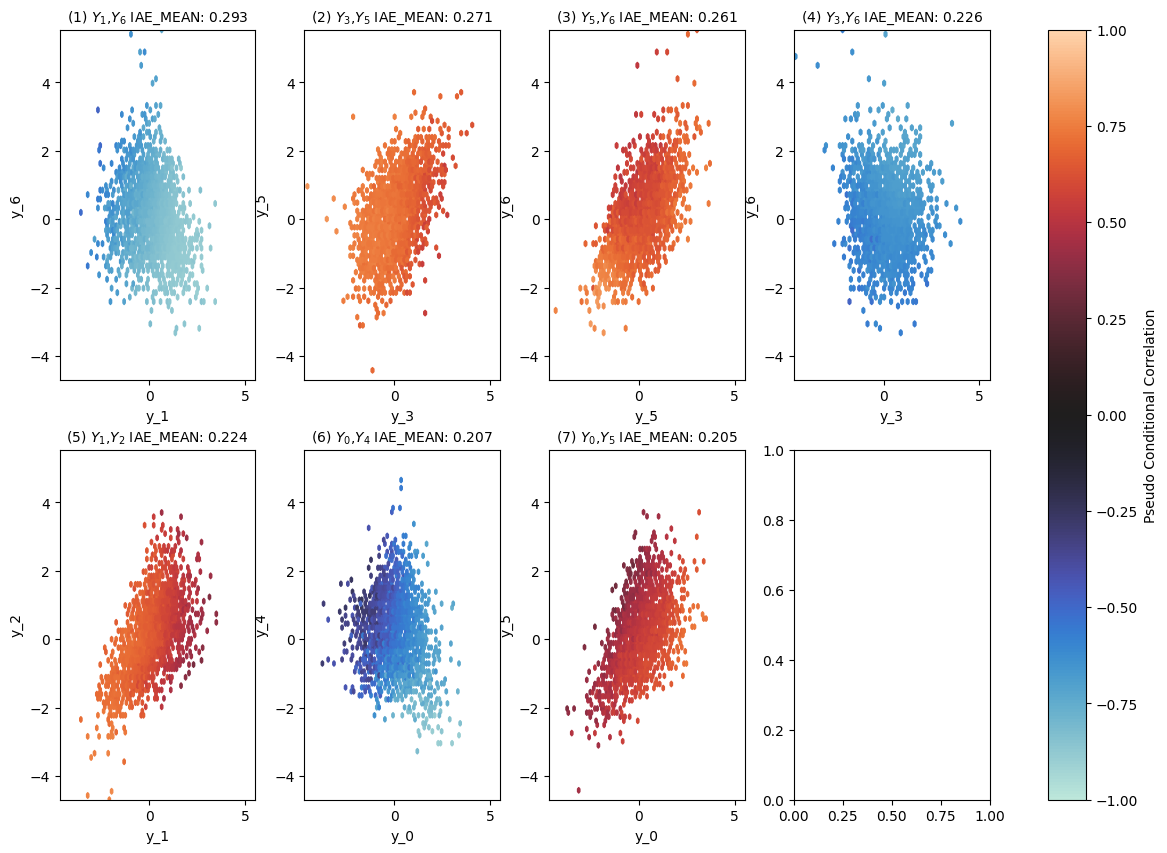

In [28]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

In [26]:
# model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [27]:
#model.plot_splines(layer_type="transformation")

In [28]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [29]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [30]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [29]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [32]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [30]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.977008,0.642034,0.493506,-0.284416,0.409091,-0.263636,-0.280519,-0.270130,-0.270130,...,0.436364,0.389610,0.396104,0.429870,0.429870,0.429870,0.428571,0.407792,0.425974,0.330664
var_row,0.977008,1.000000,0.471429,0.491827,-0.220658,0.416724,-0.195402,-0.218664,-0.204707,-0.204707,...,0.430017,0.386816,0.382163,0.422706,0.422706,0.422706,0.422706,0.401437,0.419383,0.306213
var_col,0.642034,0.471429,1.000000,0.282468,-0.349596,0.181444,-0.350261,-0.339627,-0.346938,-0.346938,...,0.281804,0.239932,0.285127,0.255883,0.255883,0.255883,0.258542,0.247908,0.261200,0.290096
abs_mean,0.493506,0.491827,0.282468,1.000000,-0.248052,0.758442,-0.236364,-0.241558,-0.245455,-0.245455,...,0.977922,0.961039,0.962338,0.948052,0.948052,0.948052,0.967532,0.963636,0.967532,0.692820
mean,-0.284416,-0.220658,-0.349596,-0.248052,1.000000,-0.220779,0.990909,0.990909,0.996104,0.996104,...,-0.190909,-0.201299,-0.200000,-0.236364,-0.236364,-0.236364,-0.202597,-0.222078,-0.236364,-0.299172
std,0.409091,0.416724,0.181444,0.758442,-0.220779,1.000000,-0.266234,-0.283117,-0.246753,-0.246753,...,0.701299,0.690909,0.711688,0.764935,0.764935,0.764935,0.759740,0.758442,0.749351,0.708566
min,-0.263636,-0.195402,-0.350261,-0.236364,0.990909,-0.266234,1.000000,0.997403,0.996104,0.996104,...,-0.176623,-0.181818,-0.189610,-0.238961,-0.238961,-0.238961,-0.200000,-0.218182,-0.231169,-0.346410
q_1,-0.280519,-0.218664,-0.339627,-0.241558,0.990909,-0.283117,0.997403,1.000000,0.996104,0.996104,...,-0.177922,-0.190909,-0.192208,-0.240260,-0.240260,-0.240260,-0.205195,-0.224675,-0.237662,-0.346410
q_5,-0.270130,-0.204707,-0.346938,-0.245455,0.996104,-0.246753,0.996104,0.996104,1.000000,1.000000,...,-0.190909,-0.205195,-0.205195,-0.249351,-0.249351,-0.249351,-0.214286,-0.233766,-0.246753,-0.346410
q_10,-0.270130,-0.204707,-0.346938,-0.245455,0.996104,-0.246753,0.996104,0.996104,1.000000,1.000000,...,-0.190909,-0.205195,-0.205195,-0.249351,-0.249351,-0.249351,-0.214286,-0.233766,-0.246753,-0.346410


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [32]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9363636363636364
AUC KLD                    : 0.9454545454545454
AUC Conditional Correlation: 0.9
AUC Precision Matrix       : 0.9090909090909092


We further print the ROC Curves for different metrics.

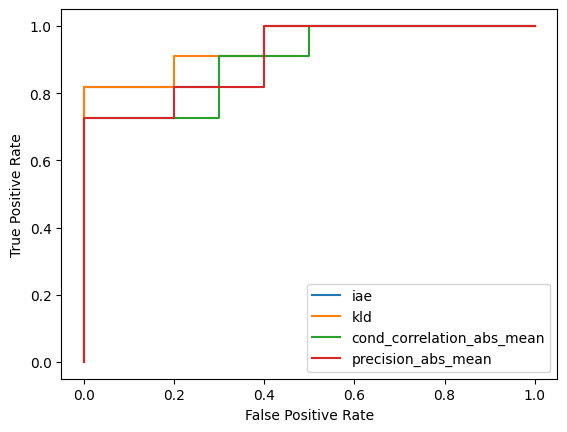

In [33]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()